In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = np.loadtxt("bobina.csv", delimiter=",")*1e-3

In [4]:
# Rectangular coil magnetic field

class square_coils(object):
    """
    MEDUSA rectangular coil class, evaluates field at any point in space.
    """
    def __init__(self, coildata, numcoils, cur):
        self.coildata = coildata
        self.numcoils = numcoils
        self.cur = cur
        self.dphi = 2*np.pi/numcoils
        self.mu=4e-7*np.pi
        self.phi = np.arange(0,2*np.pi,self.dphi)
        self.coildata = self.arrange_data() 
    
    def __call__(self, point):
        return self.calc_field(point)
        
    def arrange_data(self):
        new_coildata = np.zeros((self.numcoils, self.coildata.shape[0],3))
        new_coildata[:,:,0] = np.outer(np.cos(self.phi),self.coildata[:,0])
        new_coildata[:,:,1] = np.outer(np.sin(self.phi),self.coildata[:,0])
        new_coildata[:,:,2] = self.coildata[:,1]
        
        return new_coildata
        
    def calc_field(self, point):
        """
        Calculates field of given set of coils at a point.  
        """
            
        Rf = point - self.coildata
        _, b, _ = Rf.shape
        coef = self.mu*self.cur/4*np.pi
        e_s = np.diff(Rf, axis=1)
        L = np.sqrt(np.sum(e_s**2, axis=2))
        L_2 = np.tile(L.T, (3,1,1)).T
        e_hat = e_s/L_2
        Rfmag = np.sqrt(np.sum(Rf**2,axis=2))
        Rsum = (Rfmag[:,:-1]+Rfmag[:,1:])
        num = 2*L*(Rfmag[:,0:b-1]+Rfmag[:,1:b])#2*L*Rsum
        denom = (Rfmag[:,0:b-1]*Rfmag[:,1:b])*((Rfmag[:,0:b-1]+Rfmag[:,1:b])**2-L**2)#Rfmag[:,:-1]*Rfmag[:,1:]*(Rsum**2-L*2)
        coef_2 = num/denom
        e_vects = np.multiply(e_hat, coef)
        coef_m = np.tile(coef_2.T, (3,1,1)).T
        Ri=coef_m*Rf[:,:-1]
        B = np.cross(e_vects, Ri)
        tot = np.sum(B, axis=(0,1))
        
        return tot

In [5]:
from scipy.special import ellipk, ellipe

In [286]:
class loopcoil(object): 
    def __init__(self, radius, cur, center, n_vect):
        self.a = radius
        self.cur = cur
        self.B_0 = cur*4e-7*np.pi/(2*self.a)
        self.O = center
        self.normal = n_vect
    
    def __call__(self, point):
        self.get_position_wrt_center(point)
        return self.calc_field()
        
    def get_position_wrt_center(self, point):
        self.poswrtO = point-self.O    
        self.zvect = np.dot(self.poswrtO, self.normal)*self.normal
        self.rvect = self.poswrtO-self.zvect
        self.r = np.sqrt(np.sum(self.rvect**2))
        self.z = np.sqrt(np.sum(self.zvect**2))
        
    def Baxial(self):
        if self.a == 0: 
            if self.z == 0:
                return NaN
            else:
                return 0.0 
        else: 
            return (self.B_0*self.a**2)/(self.z**2+self.a**2)**1.5*self.normal
        
    def Br(self, C, alphasq, betasq, ksq):
        br = ((C*self.z)/(2*alphasq*np.sqrt(betasq)*self.r))*((self.a**2 +
                self.r**2 + self.z**2)*ellipe(ksq) - alphasq*ellipk(ksq))
        return br*self.rvect/self.r
        
    def Bz(self, C, alphasq, betasq, ksq):
        bz = (C/(2*alphasq*np.sqrt(betasq)))*((self.a**2 -
                self.r**2 - self.z**2)*ellipe(ksq) + alphasq*ellipk(ksq))
        return bz*self.normal
        
    def calc_field(self):
        
        C = 4e-7*self.cur
        alphasq = self.a**2+self.r**2+self.z**2-2*self.a*self.r
        betasq = self.a**2+self.r**2+self.z**2+2*self.a*self.r
        ksq = 1-alphasq/betasq
        
        br = self.Br(C, alphasq, betasq, ksq)
        bz = self.Bz(C, alphasq, betasq, ksq)       
        
        return br + bz

In [265]:
medusasqcoils = square_coils(data, 8, 2.3e3)
VFC1 = loopcoil(0.330, -500, np.array([0,0,0.181]), 
                                np.array([0,0,1]))
VFC2 = loopcoil(0.330, -500, np.array([0,0,-0.181]), 
                                np.array([0,0,1]))

EFC1 = loopcoil(0.185, 100, np.array([0,0,0.181]), 
                                np.array([0,0,1]))
EFC2 = loopcoil(0.185, -100, np.array([0,0,-0.181]), 
                                np.array([0,0,1]))

In [290]:
r = np.linspace(0.05, 0.55, num=25)
z = np.linspace(-0.14,0.14, num=25)
R,Z = np.meshgrid(r,z)

In [291]:
n = 25
Bfield = np.zeros((n,n,3))

for i in range(n): 
    for j in range(n):
        r = np.array([R[i,j], 0.0, Z[i,j]])
        Bfield[i,j] = VFC1(r)#+VFC2(r)+EFC1(r)+EFC2(r)

Bmag = np.sqrt(np.sum(Bfield**2, axis=2))

In [313]:
x = np.linspace(0.12, 0.2,num=30)
z = np.linspace(-0.01, 0.01,num=30)
X,Z = np.meshgrid(x,z)

testcoil = loopcoil(0.1, 1, np.zeros(3), np.array([0,0,1])) 
Bfield = np.zeros((30,30,3))

for i in range(30): 
    for j in range(30):
        r = np.array([X[i,j], 0.0, Z[i,j]])
        Bfield[i,j] = testcoil(r)

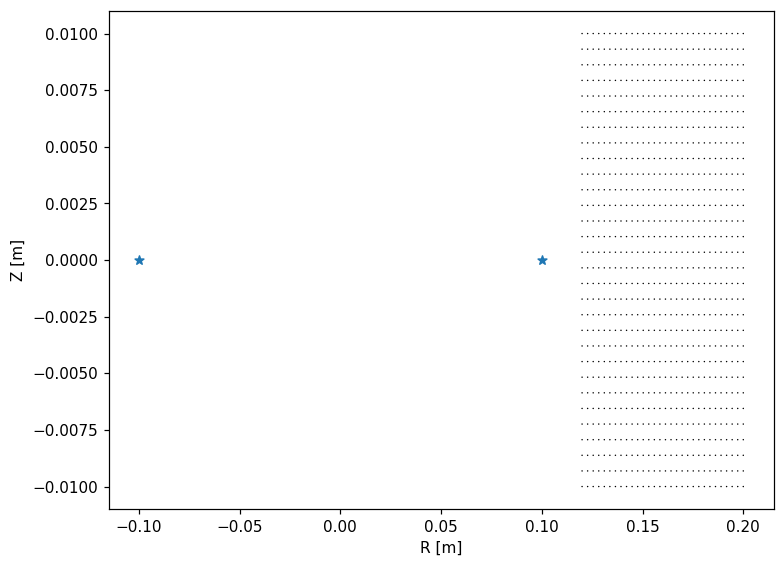

In [312]:
plt.figure(figsize=(7.8,6), dpi=110)
#plt.scatter(X, Z, c=Bfield[:,:,0])
plt.scatter([-0.1,0.1],[0.0,0.0],marker="*")
plt.quiver(X,Z,Bfield[:,:,0],Bfield[:,:,2], scale_units="dots", scale=3e-7)
#plt.colorbar(label="Magnetic Field")
plt.xlabel("R [m]")
plt.ylabel("Z [m]")
#plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

In [54]:
from scipy.special import ellipeinc, ellipkinc

In [ ]:
class solenoid(object): 
    def __init__(self, radius, center, length, axisvect):
        self.a = radius
        self.O = center
        self.length = length
        self.axis = axisvect
    
    def __call__(self, point):
    
    def get_position_wrt_center(self, point):
        self.rvect = point - self.O
        self.r = np.sqrt(np.sum(self.rvect**2))
    
    def calc_field(self, point):
        k = np.sqrt(4*self.a*self.r)
        

In [12]:
def biot(r):
    return medusasqcoils(r)+VFC1(r)+VFC2(r)+EFC1(r)+EFC2(r)

In [13]:
def RK4(b, N, p0):
    """
    Función que implementa el algoritmo de Runge-Kutta 4 vectorialmente.

    b :: metros de línea de campo
    N :: número de pasos
    p0 :: punto inicial para el cálculo
    coildata :: datos de bobinas
    """
    p = np.zeros((N+1,7))
    p[0,0:3] = p0
    p[0,4:8] = biot(p[0,0:3])
    p[0,3] = np.sqrt(np.sum(p[0,4:8]**2))
    ite = np.linspace(0,b,N+1)
    h = b/N
    
    for i in range(1,N+1):
        
        B1 = biot(p[i-1,0:3])
        k1 = B1/np.sqrt(np.sum(B1**2))
        B2 = biot(p[i-1,0:3]+h*k1/2)
        k2 = B2/np.sqrt(np.sum(B2**2))
        B3 = biot(p[i-1,0:3]+h*k2/2)
        k3 = B3/np.sqrt(np.sum(B3**2))
        B4 = biot(p[i-1,0:3]+h*k3)
        k4 = B4/np.sqrt(np.sum(B4**2))
        
        p[i,0:3] = p[i-1,0:3] + (1/6)*h*(k1+2*k2+2*k3+k4)
        p[i,4:8] = biot(p[i,0:3])
        p[i,3] = np.sqrt(np.sum(p[i,4:8]**2))

    return p, ite